In [1]:
# Import what we need
import os
import sys
import numpy as np
import scipy.io
import scipy.misc
import tensorflow as tf  # Import TensorFlow after Scipy or Scipy will break
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

In [2]:
###############################################################################
# Constants for the image input and output.
###############################################################################

# Output folder for the images.
OUTPUT_DIR = 'output/'
# Style image to use.
STYLE_IMAGE = 'images/night.jpg'
# Content image to use.
CONTENT_IMAGE = 'images/BenBi.jpg'
# Image dimensions constants. 
IMAGE_WIDTH = 750
IMAGE_HEIGHT = 750
COLOR_CHANNELS = 3

In [3]:
###############################################################################
# Algorithm constants
###############################################################################
# Noise ratio. Percentage of weight of the noise for intermixing with the
# content image.
NOISE_RATIO = 0.6
# Constant to put more emphasis on content loss.
BETA = 5
# Constant to put more emphasis on style loss.
ALPHA = 100
# Path to the deep learning model. This is more than 500MB so will not be
# included in the repository, but available to download at the model Zoo:
# Link: https://github.com/BVLC/caffe/wiki/Model-Zoo
#
# Pick the VGG 19-layer model by from the paper "Very Deep Convolutional 
# Networks for Large-Scale Image Recognition".
VGG_MODEL = 'vgg-19.mat'
# The mean to subtract from the input to the VGG model. This is the mean that
# when the VGG was used to train. Minor changes to this will make a lot of
# difference to the performance of model.
MEAN_VALUES = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))

In [4]:
def load_vgg_model(path):
    """
    Returns a model for the purpose of 'painting' the picture.
    Takes only the convolution layer weights and wrap using the TensorFlow
    Conv2d, Relu and AveragePooling layer. VGG actually uses maxpool but
    the paper indicates that using AveragePooling yields better results.
    The last few fully connected layers are not used.
    Here is the detailed configuration of the VGG model:
        0 is conv1_1 (3, 3, 3, 64)
        1 is relu
        2 is conv1_2 (3, 3, 64, 64)
        3 is relu    
        4 is maxpool
        5 is conv2_1 (3, 3, 64, 128)
        6 is relu
        7 is conv2_2 (3, 3, 128, 128)
        8 is relu
        9 is maxpool
        10 is conv3_1 (3, 3, 128, 256)
        11 is relu
        12 is conv3_2 (3, 3, 256, 256)
        13 is relu
        14 is conv3_3 (3, 3, 256, 256)
        15 is relu
        16 is conv3_4 (3, 3, 256, 256)
        17 is relu
        18 is maxpool
        19 is conv4_1 (3, 3, 256, 512)
        20 is relu
        21 is conv4_2 (3, 3, 512, 512)
        22 is relu
        23 is conv4_3 (3, 3, 512, 512)
        24 is relu
        25 is conv4_4 (3, 3, 512, 512)
        26 is relu
        27 is maxpool
        28 is conv5_1 (3, 3, 512, 512)
        29 is relu
        30 is conv5_2 (3, 3, 512, 512)
        31 is relu
        32 is conv5_3 (3, 3, 512, 512)
        33 is relu
        34 is conv5_4 (3, 3, 512, 512)
        35 is relu
        36 is maxpool
        37 is fullyconnected (7, 7, 512, 4096)
        38 is relu
        39 is fullyconnected (1, 1, 4096, 4096)
        40 is relu
        41 is fullyconnected (1, 1, 4096, 1000)
        42 is softmax
    """
    vgg = scipy.io.loadmat(path)

    vgg_layers = vgg['layers']
    def _weights(layer, expected_layer_name):
        """
        Return the weights and bias from the VGG model for a given layer.
        """
        W = vgg_layers[0][layer][0][0][2][0][0]
        b = vgg_layers[0][layer][0][0][2][0][1]
        layer_name = vgg_layers[0][layer][0][0][0][0]
        assert layer_name == expected_layer_name
        return W, b

    def _relu(conv2d_layer):
        """
        Return the RELU function wrapped over a TensorFlow layer. Expects a
        Conv2d layer input.
        """
        return tf.nn.relu(conv2d_layer)

    def _conv2d(prev_layer, layer, layer_name):
        """
        Return the Conv2D layer using the weights, biases from the VGG
        model at 'layer'.
        """
        W, b = _weights(layer, layer_name)
        W = tf.constant(W)
        b = tf.constant(np.reshape(b, (b.size)))
        return tf.nn.conv2d(
            prev_layer, filter=W, strides=[1, 1, 1, 1], padding='SAME') + b

    def _conv2d_relu(prev_layer, layer, layer_name):
        """
        Return the Conv2D + RELU layer using the weights, biases from the VGG
        model at 'layer'.
        """
        return _relu(_conv2d(prev_layer, layer, layer_name))

    def _avgpool(prev_layer):
        """
        Return the AveragePooling layer.
        """
        return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Constructs the graph model.
    graph = {}
    graph['input']   = tf.Variable(np.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)), dtype = 'float32')
    graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
    graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
    graph['avgpool1'] = _avgpool(graph['conv1_2'])
    graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
    graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
    graph['avgpool2'] = _avgpool(graph['conv2_2'])
    graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
    graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
    graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
    graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
    graph['avgpool3'] = _avgpool(graph['conv3_4'])
    graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
    graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
    graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
    graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
    graph['avgpool4'] = _avgpool(graph['conv4_4'])
    graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
    graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
    graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
    graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
    graph['avgpool5'] = _avgpool(graph['conv5_4'])
    return graph

In [5]:
def content_loss_func(sess, model):
    """
    Content loss function as defined in the paper.
    """
    def _content_loss(p, x):
        # N is the number of filters (at layer l).
        N = p.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = p.shape[1] * p.shape[2]
        # Interestingly, the paper uses this form instead:
        #
        #   0.5 * tf.reduce_sum(tf.pow(x - p, 2)) 
        #
        # But this form is very slow in "painting" and thus could be missing
        # out some constants (from what I see in other source code), so I'll
        # replicate the same normalization constant as used in style loss.
        return (1 / (4 * N * M)) * tf.reduce_sum(tf.pow(x - p, 2))
    return _content_loss(sess.run(model['conv4_2']), model['conv4_2'])

In [6]:
# Layers to use. We will use these layers as advised in the paper.
# To have softer features, increase the weight of the higher layers
# (conv5_1) and decrease the weight of the lower layers (conv1_1).
# To have harder features, decrease the weight of the higher layers
# (conv5_1) and increase the weight of the lower layers (conv1_1).
STYLE_LAYERS = [
    ('conv1_1', 0.5),
    ('conv2_1', 1.0),
    ('conv3_1', 1.5),
    ('conv4_1', 3.0),
    ('conv5_1', 4.0),
]

def style_loss_func(sess, model):
    """
    Style loss function as defined in the paper.
    """
    def _gram_matrix(F, N, M):
        """
        The gram matrix G.
        """
        Ft = tf.reshape(F, (M, N))
        return tf.matmul(tf.transpose(Ft), Ft)

    def _style_loss(a, x):
        """
        The style loss calculation.
        """
        # N is the number of filters (at layer l).
        N = a.shape[3]
        # M is the height times the width of the feature map (at layer l).
        M = a.shape[1] * a.shape[2]
        # A is the style representation of the original image (at layer l).
        A = _gram_matrix(a, N, M)
        # G is the style representation of the generated image (at layer l).
        G = _gram_matrix(x, N, M)
        result = (1 / (4 * N**2 * M**2)) * tf.reduce_sum(tf.pow(G - A, 2))
        return result

    E = [_style_loss(sess.run(model[layer_name]), model[layer_name]) for layer_name, _ in STYLE_LAYERS]
    W = [w for _, w in STYLE_LAYERS]
    loss = sum([W[l] * E[l] for l in range(len(STYLE_LAYERS))])
    return loss

In [7]:
def generate_noise_image(content_image, noise_ratio = NOISE_RATIO):
    """
    Returns a noise image intermixed with the content image at a certain ratio.
    """
    noise_image = np.random.uniform(
            -20, 20,
            (1, IMAGE_HEIGHT, IMAGE_WIDTH, COLOR_CHANNELS)).astype('float32')
    # White noise image from the content representation. Take a weighted average
    # of the values
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    return input_image

def load_image(path):
    image = scipy.misc.imread(path)
    # Resize the image for convnet input, there is no change but just
    # add an extra dimension.
    image = np.reshape(image, ((1,) + image.shape))
    # Input to the VGG model expects the mean to be subtracted.
    image = image - MEAN_VALUES
    return image

def save_image(path, image):
    # Output should add back the mean.
    image = image + MEAN_VALUES
    # Get rid of the first useless dimension, what remains is the image.
    image = image[0]
    image = np.clip(image, 0, 255).astype('uint8')
    scipy.misc.imsave(path, image)

In [8]:
sess = tf.InteractiveSession()

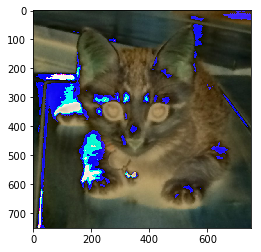

In [9]:
content_image = load_image(CONTENT_IMAGE)
imshow(content_image[0])

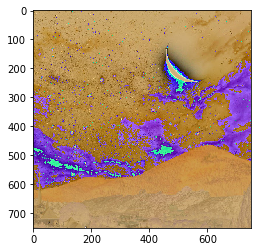

In [10]:
style_image = load_image(STYLE_IMAGE)
imshow(style_image[0])

In [11]:
model = load_vgg_model(VGG_MODEL)
print(model)

{'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 750, 750, 64) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 188, 188, 256) dtype=float32>, 'input': <tensorflow.python.ops.variables.Variable object at 0x000001DB24EBE6D8>, 'conv5_4': <tf.Tensor 'Relu_15:0' shape=(1, 47, 47, 512) dtype=float32>, 'conv4_3': <tf.Tensor 'Relu_10:0' shape=(1, 94, 94, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shape=(1, 94, 94, 512) dtype=float32>, 'conv4_4': <tf.Tensor 'Relu_11:0' shape=(1, 94, 94, 512) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 375, 375, 64) dtype=float32>, 'avgpool5': <tf.Tensor 'AvgPool_4:0' shape=(1, 24, 24, 512) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 94, 94, 512) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 94, 94, 256) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 375, 375, 128) dtype=float32>, 'conv5_1': <tf.Tensor 'Relu_12:0' shape=(1, 47, 47, 512) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0

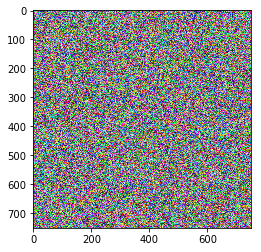

In [12]:
input_image = generate_noise_image(content_image)
imshow(input_image[0])

In [13]:
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


In [14]:
sess.run(model['input'].assign(content_image))
content_loss = content_loss_func(sess, model)

In [15]:
sess.run(model['input'].assign(style_image))
style_loss = style_loss_func(sess, model)

In [16]:
total_loss = BETA * content_loss + ALPHA * style_loss

In [17]:
optimizer = tf.train.AdamOptimizer(2.0)
train_step = optimizer.minimize(total_loss)

In [18]:
sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))

Instructions for updating:
Use `tf.global_variables_initializer` instead.


array([[[[ 27.08919525,   6.07056284,  -8.4399128 ],
         [ 26.12519264,   1.51765656, -16.39379692],
         [  4.79785299,   4.39343357,  -9.88062763],
         ..., 
         [ 13.08082771,   5.36283636,  -0.34522223],
         [  2.80167341,  13.14583111,   9.08258724],
         [ 14.04991817,   6.30183554,   8.91279316]],

        [[ 19.59816933,  11.5812149 ,  -3.13538766],
         [  9.86126518,  10.58608818,  -7.03980112],
         [ 12.34514427,   7.25532913,   0.98609585],
         ..., 
         [ -0.75427604,  17.25413513,   7.65864944],
         [ 10.01878548,  16.54922867,  13.05259323],
         [ 14.58893394,  10.17324734,  18.05952263]],

        [[ 20.08099937,  -7.28015232,  -5.7600503 ],
         [  3.93723607,   3.83968616, -16.50833702],
         [ 14.01272392,  11.29223156,  -8.66761494],
         ..., 
         [  6.52578783,  17.89382172,   2.27516961],
         [  8.16687489,   7.22468853,   5.74689579],
         [  6.60869217,  13.08246994,   0.40112844

In [19]:
# Number of iterations to run.
ITERATIONS = 1001  # The art.py uses 5000 iterations, and yields far more appealing results. If you can wait, use 5000.

In [20]:
sess.run(tf.initialize_all_variables())
sess.run(model['input'].assign(input_image))
for it in range(ITERATIONS):
    sess.run(train_step)
    if it%100 == 0:
        # Print every 100 iteration.
        mixed_image = sess.run(model['input'])
        print('Iteration %d' % (it))
        print('sum : ', sess.run(tf.reduce_sum(mixed_image)))
        print('cost: ', sess.run(total_loss))

        if not os.path.exists(OUTPUT_DIR):
            os.mkdir(OUTPUT_DIR)

        filename = 'output/%d.png' % (it)
        save_image(filename, mixed_image)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Iteration 0
sum :  -5.15209e+06
cost:  3.94503e+11
Iteration 100
sum :  -1.96391e+07
cost:  2.24753e+10
Iteration 200
sum :  -3.19643e+07
cost:  7.29244e+09
Iteration 300
sum :  -3.96939e+07
cost:  3.5989e+09
Iteration 400
sum :  -4.51939e+07
cost:  2.07523e+09
Iteration 500
sum :  -4.93629e+07
cost:  1.30828e+09
Iteration 600
sum :  -5.26246e+07
cost:  8.98621e+08
Iteration 700
sum :  -5.52837e+07
cost:  6.6858e+08
Iteration 800
sum :  -5.75343e+07
cost:  5.09749e+08
Iteration 900
sum :  -5.95205e+07
cost:  4.12668e+08
Iteration 1000
sum :  -6.13108e+07
cost:  3.62857e+08
